In [1]:
import pandas as pd
import numpy as np
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
jobs = pd.read_csv('jobs_data.csv')
jobs.rename(columns={'Unnamed: 0': 'Job Key'}, inplace=True)
jobs = jobs[["Job Key", "Title", "Description"]]

In [3]:
jobs.head()

,Job Key,Title,Description
0,0,Data Scientist,skillsdo experience web service yesno job deta...
1,1,Data Analyst / Data Scientist,skillsdo experience technical writing yesno jo...
2,2,Senior Data Engineer (Machine Learning),skillsdo experience spark yesno job detailsher...
3,3,Data Scientist (Remote Eligible),skillsdo experience tableau yesnoeducationdo b...
4,4,Data Scientist Positions,skillsdo experience research yesnoeducationdo ...


In [4]:
resumes = pd.read_csv("resume_data.csv")
resumes.rename(columns={'Unnamed: 0': 'Resume Key'}, inplace=True)

In [5]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text = str(text)
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers

In [6]:
resumes['Cleaned Description'] = resumes['Resume'].apply(remove_numbers)

In [7]:
jobs["Cleaned Description"] = jobs["Description"].apply(remove_numbers)

In [8]:
duplicate_descriptions = resumes[resumes.duplicated(subset='Cleaned Description', keep=False)]

In [9]:
resumes.drop_duplicates(subset='Cleaned Description', keep='first', inplace=True)

In [10]:
resumes.reset_index(inplace=True, drop=True)

In [11]:
resumes["Resume Key"] = resumes.index

In [12]:
resumes.head()

,Resume Key,Category,Resume,Cleaned Description
0,0,Data Science,skill programming language python panda numpy ...,skill programming language python panda numpy ...
1,1,Data Science,education detail may 2013 may 2017 data scient...,education detail may may data scientist data...
2,2,Data Science,area interest deep learning control system des...,area interest deep learning control system des...
3,3,Data Science,skill r python sap hana tableau sap hana sql s...,skill r python sap hana tableau sap hana sql s...
4,4,Data Science,education detail mca ymcaust faridabad haryana...,education detail mca ymcaust faridabad haryana...


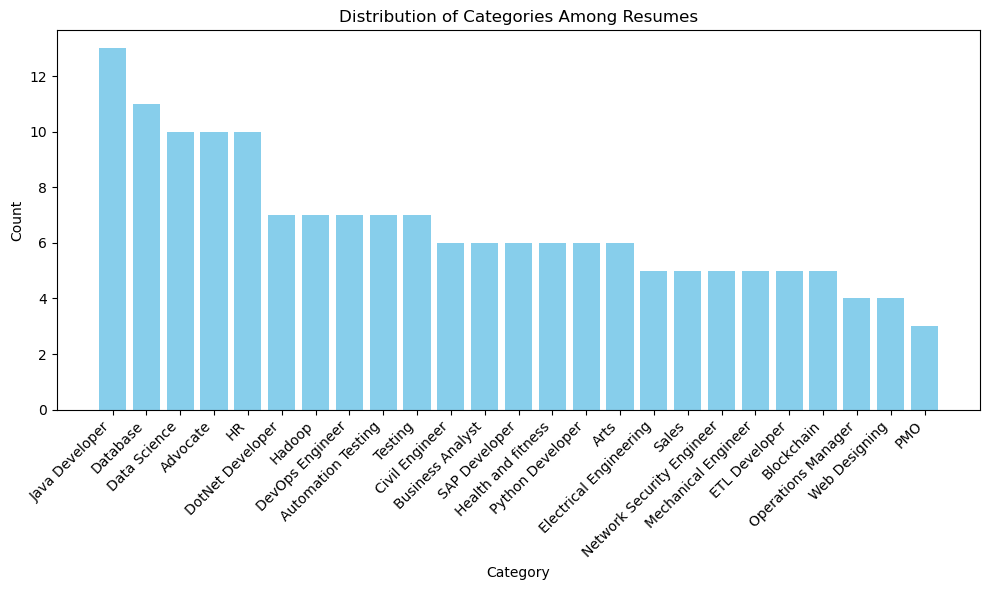

In [13]:
category_counts = resumes["Category"].value_counts()

# Plot the distribution using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.title("Distribution of Categories Among Resumes")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Model 1: Most Competitive Jobs

This model attempts to find the k most similar jobs for each resume. It utilizes cosine similarity and pretrained word embeddings. The intuition behind this model is to find the most competitive jobs and the linguistic characteristics of a competitive job description. This would help recruiters/writers of job descriptions understand the key/buzz words to include in their job descriptions in order to attract the most amount of applicants.

In [14]:
# Load pre-trained GloVe word embeddings
glove_model = api.load("glove-wiki-gigaword-100")

In [15]:
# Generate document embeddings of description text
def generate_document_embedding(desc_text, model):
    word_vectors = []
    for word in desc_text:
        if word in model.key_to_index:
            word_vectors.append(model[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Function to generate TF-IDF vectors for description text
def generate_tfidf_vectors(desc_text):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectors = tfidf_vectorizer.fit_transform(desc_text)
    return tfidf_vectors

# Calculate similarity between resumes and jobs
def calculate_similarity(resume_embedding, job_embeddings):
    # Reshape resume_embedding to be a 2D array
    resume_embedding_2d = resume_embedding.reshape(1, -1)
    
    # Reshape job_embeddings if necessary
    if len(job_embeddings.shape) == 1:
        job_embeddings = job_embeddings.reshape(1, -1)
    
    return cosine_similarity(resume_embedding_2d, job_embeddings)[0]

In [16]:
# Find top k job matches for each resume (Using word embeddings)
k = 5
top_matches = {}
for idx, resume_row in resumes.iterrows():
    print(f"Calculating Similarity for Resume: {idx}")
    resume_embedding = generate_document_embedding(resume_row['Cleaned Description'], glove_model)
    job_similarities = []
    for _, job_row in jobs.iterrows():
        job_embedding = generate_document_embedding(job_row['Cleaned Description'], glove_model)
        similarity = calculate_similarity(resume_embedding, job_embedding)
        job_similarities.append((job_row['Job Key'], similarity))
    top_matches[resume_row['Resume Key']] = sorted(job_similarities, key=lambda x: x[1], reverse=True)[:k]

Calculating Similarity for Resume: 0
Calculating Similarity for Resume: 1
Calculating Similarity for Resume: 2
Calculating Similarity for Resume: 3
Calculating Similarity for Resume: 4
Calculating Similarity for Resume: 5
Calculating Similarity for Resume: 6
Calculating Similarity for Resume: 7
Calculating Similarity for Resume: 8
Calculating Similarity for Resume: 9
Calculating Similarity for Resume: 10
Calculating Similarity for Resume: 11
Calculating Similarity for Resume: 12
Calculating Similarity for Resume: 13
Calculating Similarity for Resume: 14
Calculating Similarity for Resume: 15
Calculating Similarity for Resume: 16
Calculating Similarity for Resume: 17
Calculating Similarity for Resume: 18
Calculating Similarity for Resume: 19
Calculating Similarity for Resume: 20
Calculating Similarity for Resume: 21
Calculating Similarity for Resume: 22
Calculating Similarity for Resume: 23
Calculating Similarity for Resume: 24
Calculating Similarity for Resume: 25
Calculating Similarity

In [17]:
import warnings
warnings.filterwarnings('ignore')
# Create an example dataframe of resume with matched job description (for word embeddings)
job_match_df = pd.DataFrame(columns=['Resume Key', 'Matched Job Key', 'Similarity', 'Resume Description', 'Job Description',])

for resume_key, matches in top_matches.items():
    print(f"Creating Match Dataframe for Resume: {resume_key}")
    for job_key, similarity in matches:
        # Get the resume description
        resume_description = resumes.loc[resumes['Resume Key'] == resume_key, 'Cleaned Description'].iloc[0]
        # Get the job description
        job_description = jobs.loc[jobs['Job Key'] == job_key, 'Cleaned Description'].iloc[0]
        job_title = jobs.loc[jobs['Job Key'] == job_key, 'Title'].iloc[0]
        job_match_df = job_match_df.append({'Resume Key': resume_key, 'Matched Job Key': job_key, 
                                        'Similarity': similarity, 'Resume Description': resume_description,
                                        'Job Description': job_description, 
                                       'Job Title': job_title}, ignore_index=True)
job_match_df["Similarity"] = job_match_df["Similarity"].astype(str)
job_match_df["Similarity"] = job_match_df["Similarity"].str[1:-1]
job_match_df["Similarity"] = job_match_df["Similarity"].astype(float)

Creating Match Dataframe for Resume: 0
Creating Match Dataframe for Resume: 1
Creating Match Dataframe for Resume: 2
Creating Match Dataframe for Resume: 3
Creating Match Dataframe for Resume: 4
Creating Match Dataframe for Resume: 5
Creating Match Dataframe for Resume: 6
Creating Match Dataframe for Resume: 7
Creating Match Dataframe for Resume: 8
Creating Match Dataframe for Resume: 9
Creating Match Dataframe for Resume: 10
Creating Match Dataframe for Resume: 11
Creating Match Dataframe for Resume: 12
Creating Match Dataframe for Resume: 13
Creating Match Dataframe for Resume: 14
Creating Match Dataframe for Resume: 15
Creating Match Dataframe for Resume: 16
Creating Match Dataframe for Resume: 17
Creating Match Dataframe for Resume: 18
Creating Match Dataframe for Resume: 19
Creating Match Dataframe for Resume: 20
Creating Match Dataframe for Resume: 21
Creating Match Dataframe for Resume: 22
Creating Match Dataframe for Resume: 23
Creating Match Dataframe for Resume: 24
Creating M

In [18]:
job_match_df

,Resume Key,Matched Job Key,Similarity,Resume Description,Job Description,Job Title
0,0,49,0.999802,skill programming language python panda numpy ...,skillsdo experience statistical analysis yesno...,Data Scientist
1,0,30,0.999736,skill programming language python panda numpy ...,skillsdo experience spark yesno job detailsher...,Data Scientist
2,0,28,0.999734,skill programming language python panda numpy ...,skillsdo experience tableau yesno location th ...,Senior Data Analyst
3,0,14,0.999727,skill programming language python panda numpy ...,skillsdo experience statistic yesnoeducationdo...,Data Scientist
4,0,43,0.999727,skill programming language python panda numpy ...,skillsdo experience statistic yesnoeducationdo...,Data Scientist
...,...,...,...,...,...,...
825,165,18,0.999249,skill set o window database mysql sql server ...,skillsdo experience spark yesnoeducationdo bac...,Data Scientist
826,165,56,0.999249,skill set o window database mysql sql server ...,skillsdo experience spark yesnoeducationdo bac...,Data Scientist
827,165,41,0.999234,skill set o window database mysql sql server ...,skillsdo experience seaborn yesnoeducationdo m...,Data Scientist
828,165,42,0.999174,skill set o window database mysql sql server ...,skillsdo experience sql yesnoeducationdo maste...,Data Scientist


In [19]:
# Find top k job matches for each resume (Using tfidf vectors)
k = 5
top_matches = {}

# Concatenate all descriptions (resumes and jobs)
all_desc_texts = resumes['Cleaned Description'].tolist() + jobs['Cleaned Description'].tolist()

# Generate TF-IDF vectors for all descriptions
tfidf_vectors_all = generate_tfidf_vectors(all_desc_texts)

# Separate TF-IDF vectors for resumes and jobs
tfidf_vectors_resumes = tfidf_vectors_all[:len(resumes)]
tfidf_vectors_jobs = tfidf_vectors_all[len(resumes):]

for idx, resume_row in resumes.iterrows():
    print(f"Calculating Similarity for Resume: {idx}")
    resume_vector = tfidf_vectors_resumes[idx]
    job_similarities = []
    for jdx, job_row in jobs.iterrows():
        job_vector = tfidf_vectors_jobs[jdx]
        similarity = cosine_similarity(resume_vector, job_vector)
        job_similarities.append((job_row['Job Key'], similarity[0][0]))  # Convert similarity matrix to scalar
    top_matches[resume_row['Resume Key']] = sorted(job_similarities, key=lambda x: x[1], reverse=True)[:k]

Calculating Similarity for Resume: 0
Calculating Similarity for Resume: 1
Calculating Similarity for Resume: 2
Calculating Similarity for Resume: 3
Calculating Similarity for Resume: 4
Calculating Similarity for Resume: 5
Calculating Similarity for Resume: 6
Calculating Similarity for Resume: 7
Calculating Similarity for Resume: 8
Calculating Similarity for Resume: 9
Calculating Similarity for Resume: 10
Calculating Similarity for Resume: 11
Calculating Similarity for Resume: 12
Calculating Similarity for Resume: 13
Calculating Similarity for Resume: 14
Calculating Similarity for Resume: 15
Calculating Similarity for Resume: 16
Calculating Similarity for Resume: 17
Calculating Similarity for Resume: 18
Calculating Similarity for Resume: 19
Calculating Similarity for Resume: 20
Calculating Similarity for Resume: 21
Calculating Similarity for Resume: 22
Calculating Similarity for Resume: 23
Calculating Similarity for Resume: 24
Calculating Similarity for Resume: 25
Calculating Similarity

In [20]:
# Create an example dataframe of resume with matched job description (for tfidf)
job_match_df_tfidf = pd.DataFrame(columns=['Resume Key', 'Matched Job Key', 'Similarity', 'Resume Description', 'Job Description',])

for resume_key, matches in top_matches.items():
    print(f"Creating Match Dataframe for Resume: {resume_key}")
    for job_key, similarity in matches:
        # Get the resume description
        resume_description = resumes.loc[resumes['Resume Key'] == resume_key, 'Cleaned Description'].iloc[0]
        # Get the job description
        job_description = jobs.loc[jobs['Job Key'] == job_key, 'Cleaned Description'].iloc[0]
        job_title = jobs.loc[jobs['Job Key'] == job_key, 'Title'].iloc[0]
        job_match_df_tfidf = job_match_df_tfidf.append({'Resume Key': resume_key, 'Matched Job Key': job_key, 
                                        'Similarity': similarity, 'Resume Description': resume_description,
                                        'Job Description': job_description, 
                                       'Job Title': job_title}, ignore_index=True)
job_match_df_tfidf["Similarity"] = job_match_df_tfidf["Similarity"].astype(str)
job_match_df_tfidf["Similarity"] = job_match_df_tfidf["Similarity"].str[1:-1]
job_match_df_tfidf["Similarity"] = job_match_df_tfidf["Similarity"].astype(float)

Creating Match Dataframe for Resume: 0
Creating Match Dataframe for Resume: 1
Creating Match Dataframe for Resume: 2
Creating Match Dataframe for Resume: 3
Creating Match Dataframe for Resume: 4
Creating Match Dataframe for Resume: 5
Creating Match Dataframe for Resume: 6
Creating Match Dataframe for Resume: 7
Creating Match Dataframe for Resume: 8
Creating Match Dataframe for Resume: 9
Creating Match Dataframe for Resume: 10
Creating Match Dataframe for Resume: 11
Creating Match Dataframe for Resume: 12
Creating Match Dataframe for Resume: 13
Creating Match Dataframe for Resume: 14
Creating Match Dataframe for Resume: 15
Creating Match Dataframe for Resume: 16
Creating Match Dataframe for Resume: 17
Creating Match Dataframe for Resume: 18
Creating Match Dataframe for Resume: 19
Creating Match Dataframe for Resume: 20
Creating Match Dataframe for Resume: 21
Creating Match Dataframe for Resume: 22
Creating Match Dataframe for Resume: 23
Creating Match Dataframe for Resume: 24
Creating M

In [21]:
job_match_df_tfidf
# ANALYSIS TO DO:

#1) Determine what the most competitive jobs are (most common matched jobs)
#2) Analyze the top most matched jobs and their descriptions to see what linguistic characteristics make a job popular
# and have high degree of matching (most popular words within most popular jobs)

,Resume Key,Matched Job Key,Similarity,Resume Description,Job Description,Job Title
0,0,3,0.187537,skill programming language python panda numpy ...,skillsdo experience tableau yesnoeducationdo b...,Data Scientist (Remote Eligible)
1,0,36,0.167518,skill programming language python panda numpy ...,skillsdo experience tensorflow yesnoeducationd...,Data Scientist
2,0,7,0.163086,skill programming language python panda numpy ...,skillsdo experience tableau yesnoeducationdo m...,Data Scientist I
3,0,16,0.163086,skill programming language python panda numpy ...,skillsdo experience tableau yesnoeducationdo m...,Data Scientist I
4,0,41,0.158940,skill programming language python panda numpy ...,skillsdo experience seaborn yesnoeducationdo m...,Data Scientist
...,...,...,...,...,...,...
825,165,74,0.123675,skill set o window database mysql sql server ...,certificationsdo valid mcitp certification yes...,Desktop Support I
826,165,75,0.123675,skill set o window database mysql sql server ...,certificationsdo valid mcitp certification yes...,Desktop Support I
827,165,90,0.123675,skill set o window database mysql sql server ...,certificationsdo valid mcitp certification yes...,Desktop Support I
828,165,101,0.108938,skill set o window database mysql sql server ...,licensesdo valid license yesnocertificationsdo...,Systems / Network Administration


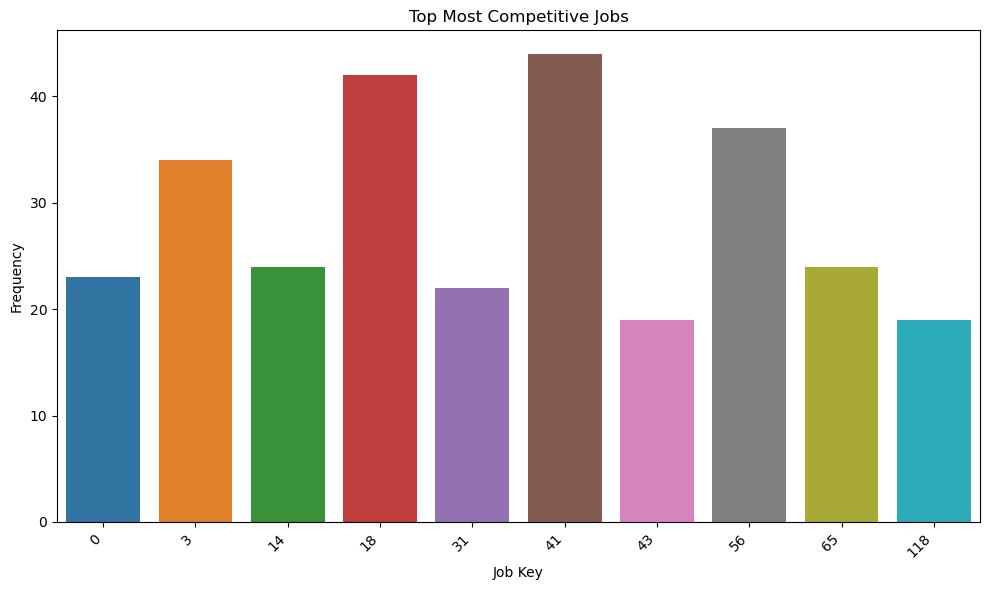

In [22]:
# Function to determine the k most competitive jobs/resumes are and show a plot of the top ones
def most_comp(df, colname, k):
    # Count the frequency of matched job keys
    most_common = df[colname].value_counts()

    # Get the top most common matched jobs/resumes
    top = most_common.head(k)
    
    return top

# Create plot showing distribution amongst top jobs/resumes
top_jobs = most_comp(job_match_df, "Matched Job Key", 10)
top_jobs.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_jobs.index, y=top_jobs.values)
plt.title("Top Most Competitive Jobs")
plt.xlabel("Job Key")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("topjobs_emb.pdf")

In [23]:
# Filter the jobs DataFrame based on the top most competitive job keys
top_jobs_df = jobs[jobs["Job Key"].isin(top_jobs.index)]

# Print the resulting DataFrame
top_jobs_df

,Job Key,Title,Description,Cleaned Description
0,0,Data Scientist,skillsdo experience web service yesno job deta...,skillsdo experience web service yesno job deta...
3,3,Data Scientist (Remote Eligible),skillsdo experience tableau yesnoeducationdo b...,skillsdo experience tableau yesnoeducationdo b...
14,14,Data Scientist,skillsdo experience statistic yesnoeducationdo...,skillsdo experience statistic yesnoeducationdo...
18,18,Data Scientist,skillsdo experience spark yesnoeducationdo bac...,skillsdo experience spark yesnoeducationdo bac...
31,31,Data Scientist,skillsdo experience window yesnoeducationdo ma...,skillsdo experience window yesnoeducationdo ma...
41,41,Data Scientist,skillsdo experience seaborn yesnoeducationdo m...,skillsdo experience seaborn yesnoeducationdo m...
43,43,Data Scientist,skillsdo experience statistic yesnoeducationdo...,skillsdo experience statistic yesnoeducationdo...
56,56,Data Scientist,skillsdo experience spark yesnoeducationdo bac...,skillsdo experience spark yesnoeducationdo bac...
65,65,Information Systems Specialist,skillsdo experience vpn yesnoeducationdo high ...,skillsdo experience vpn yesnoeducationdo high ...
118,118,System Administrator IV,skillsdo experience visual basic yesno job det...,skillsdo experience visual basic yesno job det...


In [24]:
# Function to analyze text of top most competitive jobs to determine most occuring words/phrases and linguistics
def common_words(df, colname, most_common, k):
    # Extract job/resume descriptions for the top most matched jobs/resume
    top_descriptions = df[df[f"Matched {colname} Key"].isin(most_common.index)][f'{colname} Description']
    
    # Combine all tokens into a single list
    all_text = ' '.join(top_descriptions)
    
    # Get list of words
    words = re.findall(r'\b\w+\b', all_text.lower())
    
    # Calculate word frequency
    word_freq = Counter(words)
    
    return word_freq.most_common(k)

In [25]:
most_freq_job_words = common_words(job_match_df, "Job", top_jobs, 25)
most_freq_job_words

[('data', 3564),
 ('experience', 1829),
 ('position', 1673),
 ('job', 1479),
 ('salary', 1370),
 ('team', 1087),
 ('science', 1083),
 ('model', 1070),
 ('customer', 1004),
 ('range', 999),
 ('annually', 991),
 ('applicant', 968),
 ('analytics', 709),
 ('support', 688),
 ('learning', 655),
 ('business', 645),
 ('company', 643),
 ('knowledge', 637),
 ('marriott', 632),
 ('project', 621),
 ('location', 603),
 ('benefit', 596),
 ('employee', 581),
 ('machine', 570),
 ('work', 561)]

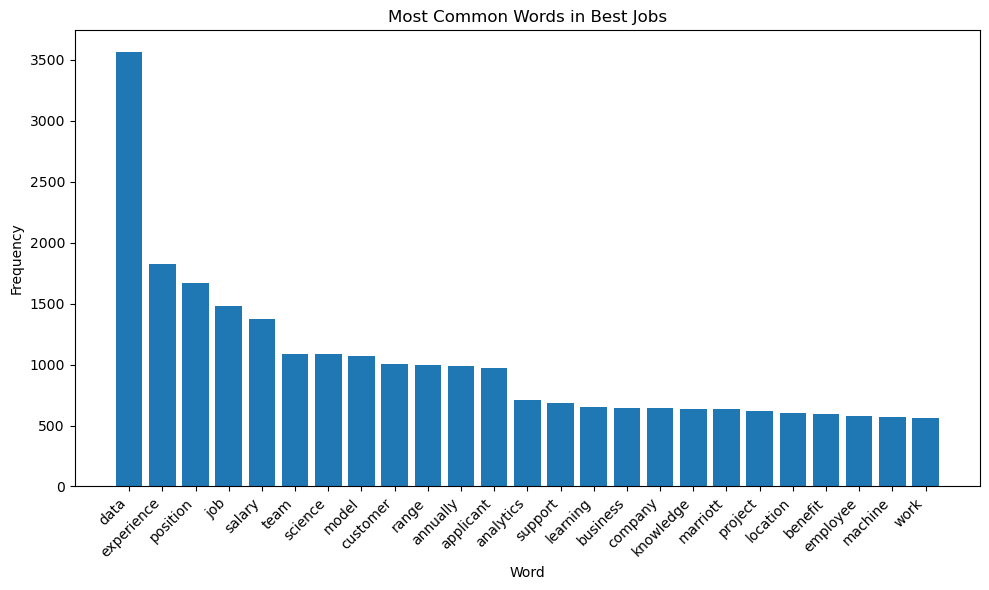

In [26]:
# Plot most common words and their frequency
words = [word for word, freq in most_freq_job_words]
frequencies = [freq for word, freq in most_freq_job_words]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Best Jobs')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_Jobs_Embd')

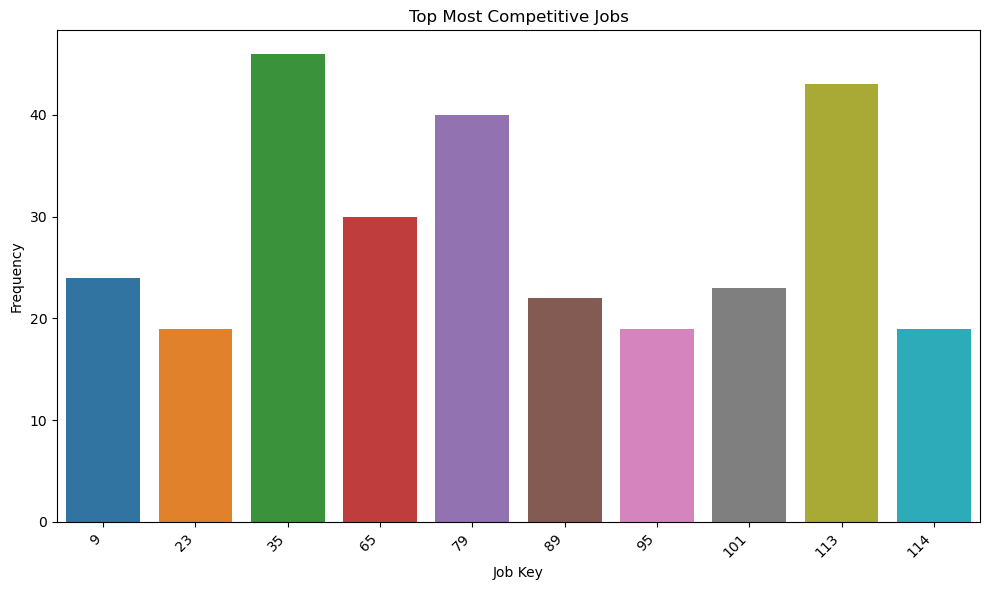

In [27]:
# Create plot showing distribution amongst top jobs/resumes
top_jobs = most_comp(job_match_df_tfidf, "Matched Job Key", 10)
top_jobs.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_jobs.index, y=top_jobs.values)
plt.title("Top Most Competitive Jobs")
plt.xlabel("Job Key")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("topjobs_tfidf.pdf")

In [28]:
# Filter the jobs DataFrame based on the top most competitive job keys
top_jobs_df = jobs[jobs["Job Key"].isin(top_jobs.index)]

# Print the resulting DataFrame
top_jobs_df

,Job Key,Title,Description,Cleaned Description
9,9,Data Scientist,skillsdo experience statistic yesnoeducationdo...,skillsdo experience statistic yesnoeducationdo...
23,23,Data Scientist,skillsdo experience statistic yesnoeducationdo...,skillsdo experience statistic yesnoeducationdo...
35,35,Data Scientists Analysts,skillsdo experience teradata yesnoeducationdo ...,skillsdo experience teradata yesnoeducationdo ...
65,65,Information Systems Specialist,skillsdo experience vpn yesnoeducationdo high ...,skillsdo experience vpn yesnoeducationdo high ...
79,79,System Administrator (virtual; remote; current...,skillsdo experience system administration yesn...,skillsdo experience system administration yesn...
89,89,PLEX ERP Analyst,skillsdo experience supervising experience yes...,skillsdo experience supervising experience yes...
95,95,Hybrid Systems Administrator,skillsdo experience window yesnoeducationdo hi...,skillsdo experience window yesnoeducationdo hi...
101,101,Systems / Network Administration,licensesdo valid license yesnocertificationsdo...,licensesdo valid license yesnocertificationsdo...
113,113,Systems Engineer,skillsdo experience vcenter yesno job detailsh...,skillsdo experience vcenter yesno job detailsh...
114,114,L3 Systems-Network Support Engineer,certificationsdo valid mcse certification yesn...,certificationsdo valid mcse certification yesn...


In [29]:
most_freq_job_words = common_words(job_match_df_tfidf, "Job", top_jobs, 25)
most_freq_job_words

[('experience', 2880),
 ('year', 2587),
 ('system', 2538),
 ('data', 2096),
 ('business', 1911),
 ('required', 1718),
 ('job', 1390),
 ('skill', 1319),
 ('server', 1228),
 ('work', 1179),
 ('service', 991),
 ('management', 956),
 ('solution', 939),
 ('environment', 906),
 ('problem', 747),
 ('related', 737),
 ('team', 715),
 ('science', 713),
 ('tool', 697),
 ('ability', 689),
 ('new', 657),
 ('develop', 631),
 ('need', 629),
 ('microsoft', 629),
 ('knowledge', 619)]

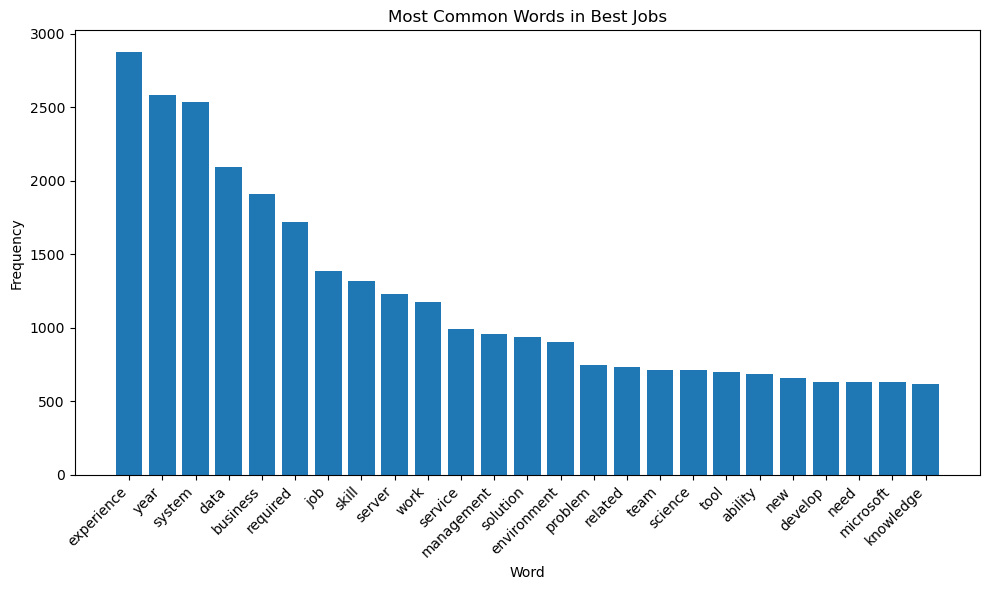

In [30]:
# Plot most common words and their frequency
words = [word for word, freq in most_freq_job_words]
frequencies = [freq for word, freq in most_freq_job_words]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Best Jobs')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_Jobs_tfidf')

### Model 2: Best Resumes

This model attempts to find the k most similar resumes for each job. It utilizes cosine similarity and pretrained word embeddings. The intuition behind this model is to find the best resumes for data science and information technology roles. By finding the top resumes for each job, we can see whether there is a trend among particular resumes which have a high amount of matches. We can then analyze the linguistic characteristics of these resumes to understand what makes them "top resumes". This is helpful for applicants to see what are important features to include in their resume to give it a high degree of matching.

In [31]:
# Find top k resume matches for each job
k = 5
top_matches = {}
for idx, job_row in jobs.iterrows():
    print(f"Finding Top Matches for Job: {idx}")
    job_embedding = generate_document_embedding(job_row['Cleaned Description'], glove_model)
    resume_similarities = []
    for _, resume_row in resumes.iterrows():
        resume_embedding = generate_document_embedding(resume_row['Cleaned Description'], glove_model)
        similarity = calculate_similarity(job_embedding, resume_embedding)
        resume_similarities.append((resume_row['Resume Key'], similarity))
    top_matches[job_row['Job Key']] = sorted(resume_similarities, key=lambda x: x[1], reverse=True)[:k]

Finding Top Matches for Job: 0
Finding Top Matches for Job: 1
Finding Top Matches for Job: 2
Finding Top Matches for Job: 3
Finding Top Matches for Job: 4
Finding Top Matches for Job: 5
Finding Top Matches for Job: 6
Finding Top Matches for Job: 7
Finding Top Matches for Job: 8
Finding Top Matches for Job: 9
Finding Top Matches for Job: 10
Finding Top Matches for Job: 11
Finding Top Matches for Job: 12
Finding Top Matches for Job: 13
Finding Top Matches for Job: 14
Finding Top Matches for Job: 15
Finding Top Matches for Job: 16
Finding Top Matches for Job: 17
Finding Top Matches for Job: 18
Finding Top Matches for Job: 19
Finding Top Matches for Job: 20
Finding Top Matches for Job: 21
Finding Top Matches for Job: 22
Finding Top Matches for Job: 23
Finding Top Matches for Job: 24
Finding Top Matches for Job: 25
Finding Top Matches for Job: 26
Finding Top Matches for Job: 27
Finding Top Matches for Job: 28
Finding Top Matches for Job: 29
Finding Top Matches for Job: 30
Finding Top Matche

In [32]:
matched_resumes = pd.DataFrame(columns=['Job Key', 'Matched Resume Key', 'Similarity', 'Resume Description', 'Job Description'])

for job_key, matches in top_matches.items():
    print(f"Creating Match Dataframe for Job: {job_key}")
    for resume_key, similarity in matches:
        # Get the resume description
        resume_description = resumes.loc[resumes['Resume Key'] == resume_key, 'Cleaned Description'].iloc[0]
        # Get the job description
        job_description = jobs.loc[jobs['Job Key'] == job_key, 'Cleaned Description'].iloc[0]
        matched_resumes = matched_resumes.append({'Job Key': job_key, 'Matched Resume Key': resume_key, 
                                        'Similarity': similarity, 'Resume Description': resume_description,
                                        'Job Description': job_description}, ignore_index=True)
matched_resumes["Similarity"] = matched_resumes["Similarity"].astype(str)
matched_resumes["Similarity"] = matched_resumes["Similarity"].str[1:-1]
matched_resumes["Similarity"] = matched_resumes["Similarity"].astype(float)

Creating Match Dataframe for Job: 0
Creating Match Dataframe for Job: 1
Creating Match Dataframe for Job: 2
Creating Match Dataframe for Job: 3
Creating Match Dataframe for Job: 4
Creating Match Dataframe for Job: 5
Creating Match Dataframe for Job: 6
Creating Match Dataframe for Job: 7
Creating Match Dataframe for Job: 8
Creating Match Dataframe for Job: 9
Creating Match Dataframe for Job: 10
Creating Match Dataframe for Job: 11
Creating Match Dataframe for Job: 12
Creating Match Dataframe for Job: 13
Creating Match Dataframe for Job: 14
Creating Match Dataframe for Job: 15
Creating Match Dataframe for Job: 16
Creating Match Dataframe for Job: 17
Creating Match Dataframe for Job: 18
Creating Match Dataframe for Job: 19
Creating Match Dataframe for Job: 20
Creating Match Dataframe for Job: 21
Creating Match Dataframe for Job: 22
Creating Match Dataframe for Job: 23
Creating Match Dataframe for Job: 24
Creating Match Dataframe for Job: 25
Creating Match Dataframe for Job: 26
Creating Ma

In [33]:
matched_resumes
# ANALYSIS TO DO:

#1) Determine what the best resumes are (most common matched resumes)
#2) Analyze the top most matched resumes and their descriptions to see what linguistic characteristics make a resume popular
# and have high degree of matching (most popular words within most popular resumes)

,Job Key,Matched Resume Key,Similarity,Resume Description,Job Description
0,0,55,0.999725,education detail may diploma nutrition educat...,skillsdo experience web service yesno job deta...
1,0,24,0.999699,skill know english native speaker ielts overal...,skillsdo experience web service yesno job deta...
2,0,27,0.999647,skill legal writing efficient researcher legal...,skillsdo experience web service yesno job deta...
3,0,142,0.999531,technical summary knowledge informatica power ...,skillsdo experience web service yesno job deta...
4,0,127,0.999510,skillset oracle dba mysql mariadb postgresql d...,skillsdo experience web service yesno job deta...
...,...,...,...,...,...
595,119,111,0.999639,core competency ant maven git bitbucket jenkin...,skillsdo experience project management yesnoed...
596,119,39,0.999620,skill language c basic java basic web technolo...,skillsdo experience project management yesnoed...
597,119,102,0.999608,education detail august electronics pune maha...,skillsdo experience project management yesnoed...
598,119,116,0.999608,skill set experience implementing troubleshoot...,skillsdo experience project management yesnoed...


In [34]:
for idx, job_row in jobs.iterrows():
    print(f"Calculating Similarity for Job: {idx}")
    job_vector = tfidf_vectors_jobs[idx]
    res_similarities = []
    for rdx, resume_row in resumes.iterrows():
        resume_vector = tfidf_vectors_resumes[rdx]
        similarity = cosine_similarity(resume_vector, job_vector)
        res_similarities.append((resume_row['Resume Key'], similarity[0][0]))  # Convert similarity matrix to scalar
    top_matches[job_row['Job Key']] = sorted(res_similarities, key=lambda x: x[1], reverse=True)[:k]

Calculating Similarity for Job: 0
Calculating Similarity for Job: 1
Calculating Similarity for Job: 2
Calculating Similarity for Job: 3
Calculating Similarity for Job: 4
Calculating Similarity for Job: 5
Calculating Similarity for Job: 6
Calculating Similarity for Job: 7
Calculating Similarity for Job: 8
Calculating Similarity for Job: 9
Calculating Similarity for Job: 10
Calculating Similarity for Job: 11
Calculating Similarity for Job: 12
Calculating Similarity for Job: 13
Calculating Similarity for Job: 14
Calculating Similarity for Job: 15
Calculating Similarity for Job: 16
Calculating Similarity for Job: 17
Calculating Similarity for Job: 18
Calculating Similarity for Job: 19
Calculating Similarity for Job: 20
Calculating Similarity for Job: 21
Calculating Similarity for Job: 22
Calculating Similarity for Job: 23
Calculating Similarity for Job: 24
Calculating Similarity for Job: 25
Calculating Similarity for Job: 26
Calculating Similarity for Job: 27
Calculating Similarity for Job

In [35]:
matched_resumes_tfidf = pd.DataFrame(columns=['Job Key', 'Matched Resume Key', 'Similarity', 'Resume Description', 'Job Description'])

for job_key, matches in top_matches.items():
    print(f"Creating Match Dataframe for Job: {job_key}")
    for resume_key, similarity in matches:
        # Get the resume description
        resume_description = resumes.loc[resumes['Resume Key'] == resume_key, 'Cleaned Description'].iloc[0]
        # Get the job description
        job_description = jobs.loc[jobs['Job Key'] == job_key, 'Cleaned Description'].iloc[0]
        matched_resumes_tfidf = matched_resumes_tfidf.append({'Job Key': job_key, 'Matched Resume Key': resume_key, 
                                        'Similarity': similarity, 'Resume Description': resume_description,
                                        'Job Description': job_description}, ignore_index=True)
matched_resumes_tfidf["Similarity"] = matched_resumes_tfidf["Similarity"].astype(str)
matched_resumes_tfidf["Similarity"] = matched_resumes_tfidf["Similarity"].str[1:-1]
matched_resumes_tfidf["Similarity"] = matched_resumes_tfidf["Similarity"].astype(float)

Creating Match Dataframe for Job: 0
Creating Match Dataframe for Job: 1
Creating Match Dataframe for Job: 2
Creating Match Dataframe for Job: 3
Creating Match Dataframe for Job: 4
Creating Match Dataframe for Job: 5
Creating Match Dataframe for Job: 6
Creating Match Dataframe for Job: 7
Creating Match Dataframe for Job: 8
Creating Match Dataframe for Job: 9
Creating Match Dataframe for Job: 10
Creating Match Dataframe for Job: 11
Creating Match Dataframe for Job: 12
Creating Match Dataframe for Job: 13
Creating Match Dataframe for Job: 14
Creating Match Dataframe for Job: 15
Creating Match Dataframe for Job: 16
Creating Match Dataframe for Job: 17
Creating Match Dataframe for Job: 18
Creating Match Dataframe for Job: 19
Creating Match Dataframe for Job: 20
Creating Match Dataframe for Job: 21
Creating Match Dataframe for Job: 22
Creating Match Dataframe for Job: 23
Creating Match Dataframe for Job: 24
Creating Match Dataframe for Job: 25
Creating Match Dataframe for Job: 26
Creating Ma

ValueError: could not convert string to float: '.'

In [36]:
matched_resumes_tfidf

,Job Key,Matched Resume Key,Similarity,Resume Description,Job Description
0,0,6,.253468471544159,skill python tableau data visualization r stud...,skillsdo experience web service yesno job deta...
1,0,9,.2194282676669000,expertise data quantitative analysis decision ...,skillsdo experience web service yesno job deta...
2,0,7,.2029182303826629,education detail rayat bahra institute enginee...,skillsdo experience web service yesno job deta...
3,0,8,.1912649228381177,personal skill ability quickly grasp technical...,skillsdo experience web service yesno job deta...
4,0,134,.154101244745581,technical skill sql oracle v v v r programming...,skillsdo experience web service yesno job deta...
...,...,...,...,...,...
595,119,40,.222682322191261,education detail may september diploma mecha...,skillsdo experience project management yesnoed...
596,119,99,.1468682023944201,education detail bca vinayaka mission universi...,skillsdo experience project management yesnoed...
597,119,121,.142136419000794,core competency maintain process ensure projec...,skillsdo experience project management yesnoed...
598,119,49,.1415303594355937,skill set collaborative optimistic thinking ef...,skillsdo experience project management yesnoed...


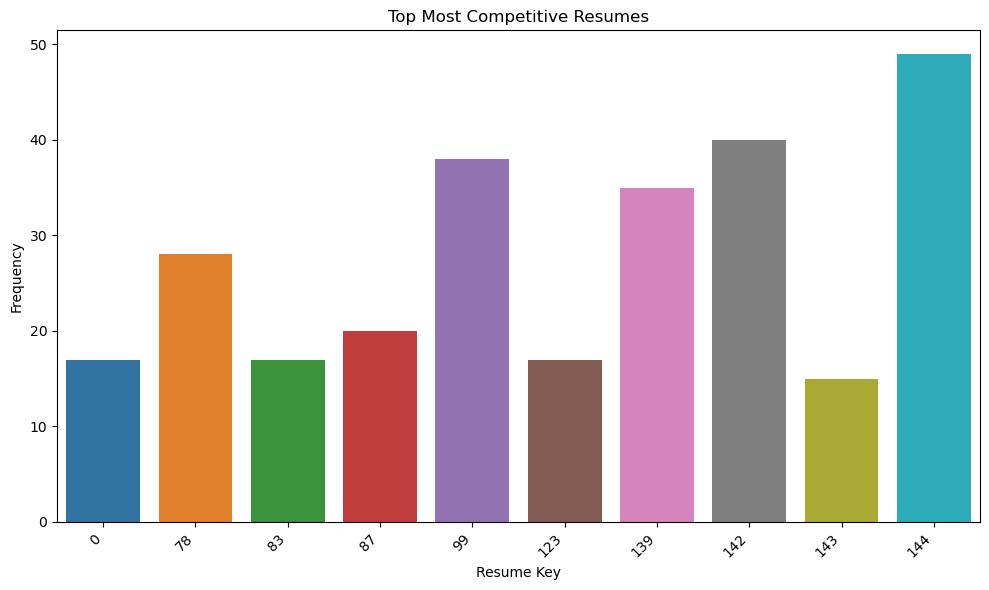

In [37]:
# Create plot showing distribution amongst top jobs/resumes
top_resumes_emb = most_comp(matched_resumes, "Matched Resume Key", 10)
top_resumes_emb.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_resumes_emb.index, y=top_resumes_emb.values)
plt.title("Top Most Competitive Resumes")
plt.xlabel("Resume Key")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("topres_emb.pdf")

In [38]:
# Filter the resume DataFrame based on the top most competitive resume keys
top_res_df_em = resumes[resumes["Resume Key"].isin(top_resumes_emb.index)]

# Print the resulting DataFrame
top_res_df_em

,Resume Key,Category,Resume,Cleaned Description
0,0,Data Science,skill programming language python panda numpy ...,skill programming language python panda numpy ...
78,78,Business Analyst,skill area exposure modeling tool bizagi m vis...,skill area exposure modeling tool bizagi m vis...
83,83,SAP Developer,education detail july 2008 february 2012 compu...,education detail july february computer scie...
87,87,Automation Testing,excellent grasping power learning new concept ...,excellent grasping power learning new concept ...
99,99,Operations Manager,education detail bca vinayaka mission universi...,education detail bca vinayaka mission universi...
123,123,PMO,skill exceptional communication networking ski...,skill exceptional communication networking ski...
139,139,Hadoop,technical skill set programming language apach...,technical skill set programming language apach...
142,142,ETL Developer,technical summary knowledge informatica power ...,technical summary knowledge informatica power ...
143,143,ETL Developer,technicalproficiencies db oracle 11g domain in...,technicalproficiencies db oracle g domain inve...
144,144,ETL Developer,education detail january 2015 bachelor enginee...,education detail january bachelor engineering...


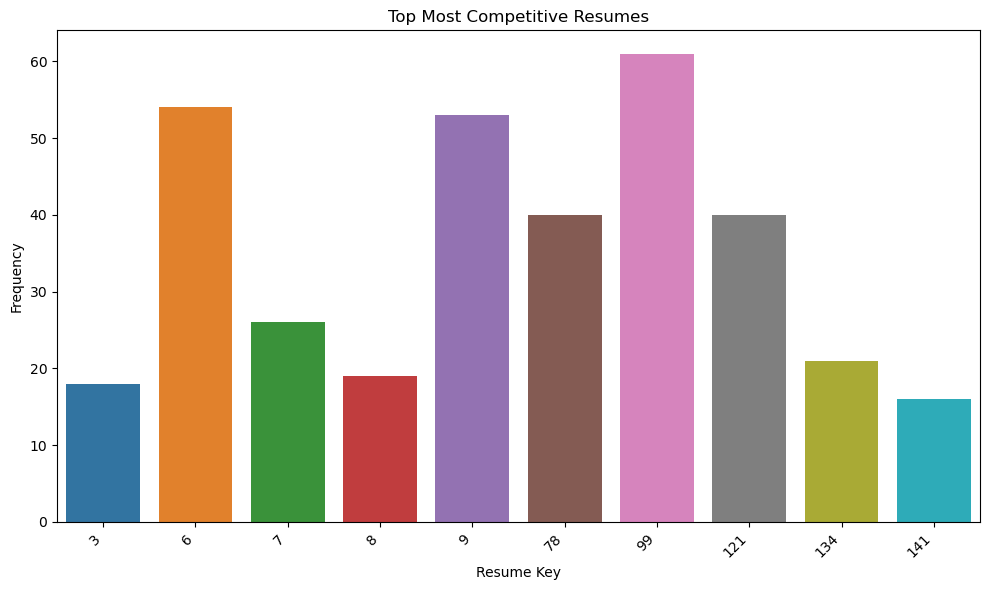

In [39]:
# Create plot showing distribution amongst top jobs/resumes
top_resumes_tfidf = most_comp(matched_resumes_tfidf, "Matched Resume Key", 10)
top_resumes_tfidf.sort_values(inplace=True, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_resumes_tfidf.index, y=top_resumes_tfidf.values)
plt.title("Top Most Competitive Resumes")
plt.xlabel("Resume Key")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("topres_tfidf.pdf")

In [40]:
# Filter the resume DataFrame based on the top most competitive resume keys
top_res_df_tf = resumes[resumes["Resume Key"].isin(top_resumes_tfidf.index)]

# Print the resulting DataFrame
top_res_df_tf

,Resume Key,Category,Resume,Cleaned Description
3,3,Data Science,skill r python sap hana tableau sap hana sql s...,skill r python sap hana tableau sap hana sql s...
6,6,Data Science,skill python tableau data visualization r stud...,skill python tableau data visualization r stud...
7,7,Data Science,education detail rayat bahra institute enginee...,education detail rayat bahra institute enginee...
8,8,Data Science,personal skill ability quickly grasp technical...,personal skill ability quickly grasp technical...
9,9,Data Science,expertise data quantitative analysis decision ...,expertise data quantitative analysis decision ...
78,78,Business Analyst,skill area exposure modeling tool bizagi m vis...,skill area exposure modeling tool bizagi m vis...
99,99,Operations Manager,education detail bca vinayaka mission universi...,education detail bca vinayaka mission universi...
121,121,PMO,core competency maintain process ensure projec...,core competency maintain process ensure projec...
134,134,Database,technical skill sql oracle v10 v11 v12 r progr...,technical skill sql oracle v v v r programming...
141,141,Hadoop,technical skill set big data ecosystem hadoop ...,technical skill set big data ecosystem hadoop ...


In [41]:
most_freq_res_words1 = common_words(matched_resumes, "Resume", top_resumes_emb, 25)
most_freq_res_words1

[('data', 2285),
 ('team', 1839),
 ('business', 1538),
 ('project', 1526),
 ('service', 1504),
 ('process', 1334),
 ('description', 1249),
 ('company', 1227),
 ('exprience', 1167),
 ('requirement', 1147),
 ('month', 1045),
 ('management', 1013),
 ('detail', 994),
 ('user', 863),
 ('test', 858),
 ('work', 827),
 ('etl', 826),
 ('tool', 826),
 ('client', 802),
 ('testing', 791),
 ('using', 772),
 ('technology', 770),
 ('issue', 741),
 ('hadoop', 735),
 ('operation', 687)]

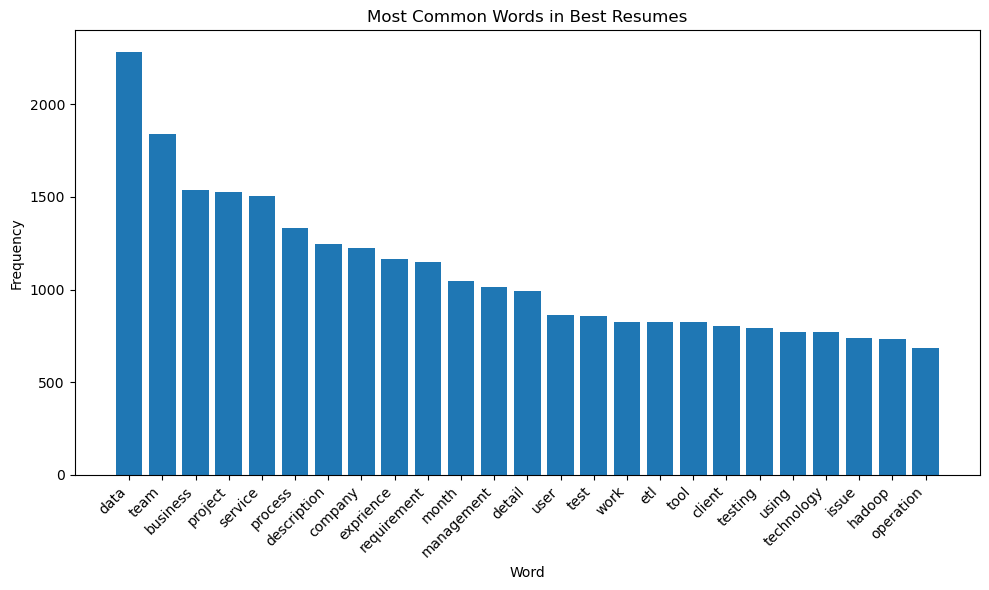

In [42]:
# Plot most common words and their frequency
words = [word for word, freq in most_freq_res_words1]
frequencies = [freq for word, freq in most_freq_res_words1]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Best Resumes')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_emb')

In [43]:
most_freq_res_words2 = common_words(matched_resumes_tfidf, "Resume", top_resumes_tfidf, 25)
most_freq_res_words2

[('data', 3786),
 ('team', 2893),
 ('business', 2555),
 ('project', 2342),
 ('service', 2013),
 ('month', 1770),
 ('exprience', 1756),
 ('company', 1714),
 ('management', 1714),
 ('process', 1569),
 ('science', 1373),
 ('description', 1324),
 ('user', 1294),
 ('report', 1279),
 ('client', 1228),
 ('work', 1198),
 ('machine', 1159),
 ('learning', 1153),
 ('detail', 1143),
 ('skill', 1100),
 ('operation', 1094),
 ('requirement', 1084),
 ('customer', 1051),
 ('using', 1004),
 ('technology', 917)]

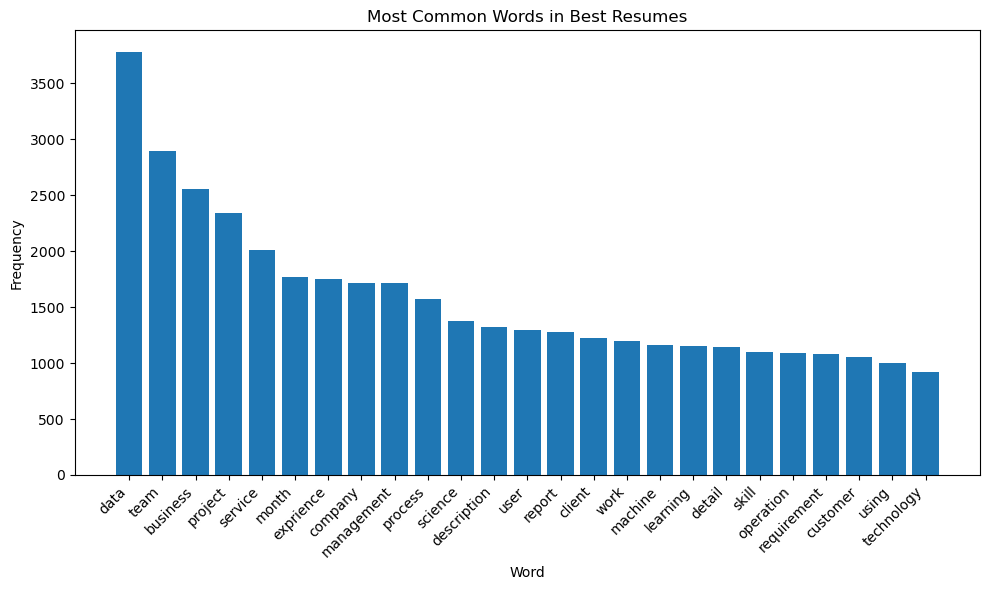

In [44]:
# Plot most common words and their frequency
words = [word for word, freq in most_freq_res_words2]
frequencies = [freq for word, freq in most_freq_res_words2]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Best Resumes')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_tf')

### Model 3: Predicting Resume Targets

Each resume has a field for the resume category, which is the intended field/type of jobs that the resume is targeting. Our next set of models aims to perform a multi-class classification to classify resumes to their intended fields based on the resume description, and top matching job title and job description. The intuition behind this model is for people to understand if their resume experiences and corresponding jobs match the field they are trying to enter. For example, perhaps a person is trying to only apply for data science roles, but according to their resume and the jobs they are closely matching to, their target field should be information technology or software development. We will employ a series of classification models including: Random Forest Classification, SVM, and Naive Bayes. In evaluating the accuracy of our models, we will pay attention to resumes that are "misclassified." More closely looking at these resumes, we can determine whether the misclassification is a model error, or is a case of a resume not matching its intended field and being better suited for a different field.

In [45]:
# Create feature dataframe
features = job_match_df.drop_duplicates(subset='Resume Key', keep='first')
category_dict = resumes["Category"].to_dict()
features["Resume Category"] = features["Resume Key"].map(category_dict)
features.reset_index(inplace=True, drop=True)
target = features["Resume Category"]
features = features[["Resume Description", "Job Description", "Job Title", "Similarity"]]
features.head()

,Resume Description,Job Description,Job Title,Similarity
0,skill programming language python panda numpy ...,skillsdo experience statistical analysis yesno...,Data Scientist,0.999802
1,education detail may may data scientist data...,skillsdo experience statistic yesnoeducationdo...,Data Scientist,0.999517
2,area interest deep learning control system des...,skillsdo experience scipy yesnoeducationdo mas...,Data Scientist,0.999294
3,skill r python sap hana tableau sap hana sql s...,skillsdo experience statistical analysis yesno...,Data Scientist,0.999764
4,education detail mca ymcaust faridabad haryana...,skillsdo experience statistic yesnoeducationdo...,Data Scientist,0.997965


In [46]:
# Use Tf-Idf vectorizer to convert text data into numerical feature

# Create vocabulary corpus
corpus = pd.concat([features['Resume Description'], features['Job Description']], axis=1)
corpus['Combined'] = corpus.apply(lambda row: row['Resume Description'] + ' ' + row['Job Description'], axis=1)

# Create corpus for job titles
job_corpus = features["Job Title"]

# Create TF-IDF vectorizer instance and fit on the combined corpus
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(corpus["Combined"])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create TF-IDF vectorizer for job corpus
tfidf_vectorizer = TfidfVectorizer()
job_features = tfidf_vectorizer.fit_transform(job_corpus)
job_feature_names = tfidf_vectorizer.get_feature_names_out()

In [47]:
tfidf_features.shape

(166, 7555)

In [48]:
# Convert sparse matrix to DataFrame
all_features_df = pd.DataFrame(tfidf_features.toarray(), columns=feature_names)
all_jobs_df = pd.DataFrame(job_features.toarray(), columns=job_feature_names)

# Concatenate other features with the TF-IDF features DataFrame
train_data = pd.concat([all_features_df, all_jobs_df, features['Similarity']], axis=1)

In [49]:
# Train-test split
indices = range(len(train_data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=target, random_state=42)

# Use the indices to split the data
X_train = train_data.iloc[train_indices]
X_test = train_data.iloc[test_indices]
y_train = target.iloc[train_indices]
y_test = target.iloc[test_indices]

# Define the classifier
clf = RandomForestClassifier(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_clf = grid_search.best_estimator_
preds = best_clf.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, preds)
print("Best Model Accuracy:", accuracy)
print("Best Parameters:", grid_search.best_params_)

Best Model Accuracy: 0.4117647058823529
Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [50]:
model1_comp = pd.DataFrame(zip(list(y_test), list(preds)), columns = ["Actual Category", "Predicted Category"])
model1_comp.insert(0, "Resume Key", test_indices)

In [51]:
model1_comp

,Resume Key,Actual Category,Predicted Category
0,132,Database,Database
1,40,Mechanical Engineer,Operations Manager
2,157,Blockchain,Java Developer
3,115,DevOps Engineer,Testing
4,56,Civil Engineer,Civil Engineer
5,117,Network Security Engineer,Network Security Engineer
6,123,PMO,Java Developer
7,83,SAP Developer,SAP Developer
8,17,HR,HR
9,102,Operations Manager,DevOps Engineer


In [52]:
# Model 2: SVM

# Define the classifier
svm_clf = SVC(random_state=42)

# Define the hyperparameters grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform grid search cross-validation
grid_search_svm = GridSearchCV(svm_clf, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Get the best SVM model
best_svm_clf = grid_search_svm.best_estimator_
svm_preds = best_svm_clf.predict(X_test)

# Evaluate the best SVM model
svm_accuracy = accuracy_score(y_test, svm_preds)
print("Best SVM Model Accuracy:", svm_accuracy)
print("Best SVM Parameters:", grid_search_svm.best_params_)

Best SVM Model Accuracy: 0.11764705882352941
Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [53]:
model2_comp = pd.DataFrame(zip(list(y_test), list(svm_preds)), columns = ["Actual Category", "Predicted Category"])
model2_comp.insert(0, "Resume Key", test_indices)
model2_comp

,Resume Key,Actual Category,Predicted Category
0,132,Database,Arts
1,40,Mechanical Engineer,Business Analyst
2,157,Blockchain,DevOps Engineer
3,115,DevOps Engineer,Testing
4,56,Civil Engineer,Java Developer
5,117,Network Security Engineer,Java Developer
6,123,PMO,Java Developer
7,83,SAP Developer,Java Developer
8,17,HR,Database
9,102,Operations Manager,Java Developer


In [54]:
# Analysis: The best model was the Random Forest classifier. In order to further analyze misclassifications, we will 
# look at a few examples of where the predicted did not match the actual to understand why the model classified it as is.

In [55]:
# Example 1: Resume Key: 40 Actual: Mechanical Engineer Predicted: Operations Manager

In [56]:
test_resume = resumes[resumes["Resume Key"] == 40]

In [67]:
# Function to determine word counts
from collections import Counter

def count_words(text, n):
    # Split the text into words
    words = text.split()
    
    # Count the occurrence of each word
    word_counts = Counter(words)
    
    # Get 25 most frequent words in resume
    top_words = word_counts.most_common(n)
    
    return top_words

In [68]:
test_res_wordcounts = count_words(test_resume["Cleaned Description"].iloc[0], 25)

In [69]:
test_res_wordcounts

[('vendor', 21),
 ('product', 17),
 ('customer', 17),
 ('project', 16),
 ('technical', 12),
 ('engineering', 10),
 ('company', 10),
 ('cost', 10),
 ('process', 10),
 ('role', 9),
 ('sale', 9),
 ('quotation', 9),
 ('solution', 9),
 ('time', 9),
 ('development', 9),
 ('supply', 9),
 ('mechanical', 8),
 ('responsibility', 8),
 ('requirement', 8),
 ('proposal', 8),
 ('manufacturing', 8),
 ('description', 7),
 ('material', 7),
 ('review', 7),
 ('order', 7)]

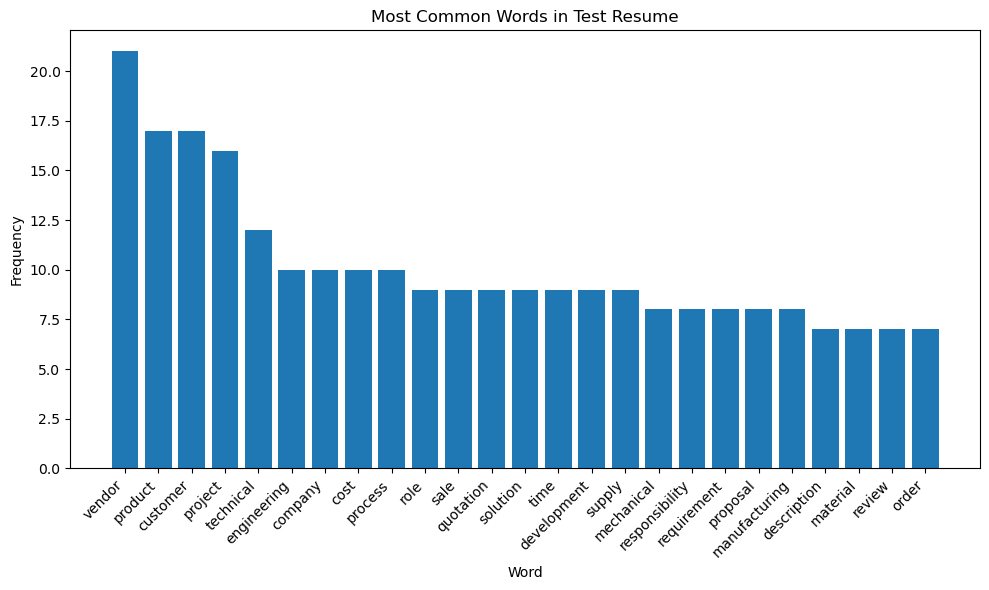

In [71]:
# Plot most common words and their frequency
words = [word for word, freq in test_res_wordcounts]
frequencies = [freq for word, freq in test_res_wordcounts]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Test Resume')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_test')

In [72]:
# This resume is actually a mechanical engineer but predicts operations manager. For analysis, we should look at the 
# most common words among the mechanical engineer and operations manager resumes and compare to the test resume to 
# understand why the model may have misclassified the resumes.

In [76]:
op_managers = resumes[resumes["Category"] == "Operations Manager"]
op_corpus = []
for i in range(len(op_managers)):
    op_corpus.append(op_managers["Cleaned Description"].iloc[i])
    op_str = ' '.join(op_corpus)

In [78]:
op_wc = count_words(op_str, 25)

In [79]:
op_wc

[('team', 68),
 ('company', 62),
 ('operation', 53),
 ('client', 53),
 ('project', 53),
 ('service', 50),
 ('customer', 41),
 ('management', 35),
 ('ensuring', 32),
 ('activity', 30),
 ('system', 30),
 ('description', 29),
 ('process', 28),
 ('quality', 25),
 ('manager', 24),
 ('development', 24),
 ('control', 24),
 ('work', 23),
 ('business', 22),
 ('meeting', 22),
 ('job', 20),
 ('ge', 20),
 ('india', 19),
 ('timely', 19),
 ('ensure', 18)]

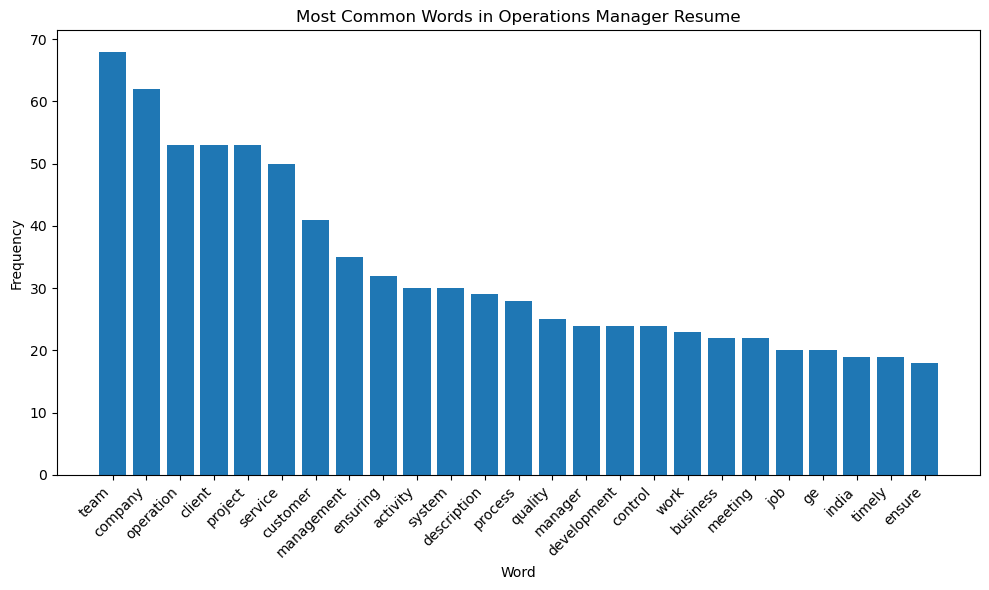

In [80]:
# Plot most common words and their frequency
words = [word for word, freq in op_wc]
frequencies = [freq for word, freq in op_wc]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Operations Manager Resume')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_OM')

In [109]:
mech_eng = resumes[resumes["Category"] == "Mechanical Engineer"]
mech_eng = mech_eng[mech_eng["Resume Key"] != 40] # drop current resume testing on
me_corpus = []
for i in range(len(mech_eng)):
    me_corpus.append(mech_eng["Cleaned Description"].iloc[i])
    me_str = ' '.join(me_corpus)
me_wc = count_words(me_str, 25)

In [110]:
me_wc

[('mechanical', 16),
 ('engineering', 16),
 ('detail', 12),
 ('design', 12),
 ('company', 10),
 ('machine', 9),
 ('skill', 7),
 ('training', 7),
 ('exprience', 7),
 ('description', 7),
 ('project', 6),
 ('pune', 6),
 ('engineer', 6),
 ('wave', 6),
 ('experience', 5),
 ('pvt', 5),
 ('student', 5),
 ('year', 5),
 ('conducted', 5),
 ('working', 5),
 ('college', 5),
 ('plastering', 5),
 ('work', 4),
 ('industrial', 4),
 ('day', 4)]

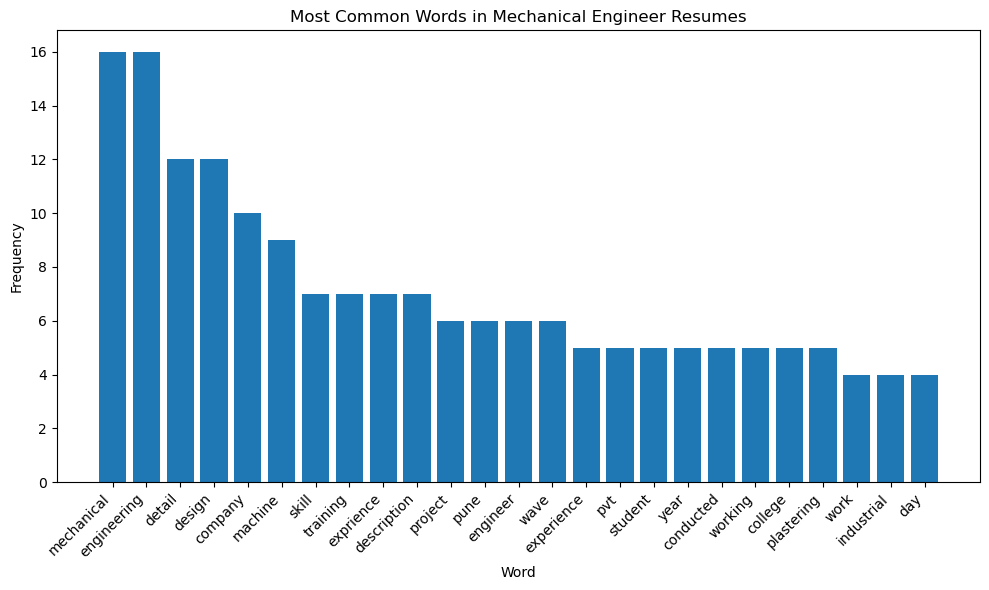

In [111]:
# Plot most common words and their frequency
words = [word for word, freq in me_wc]
frequencies = [freq for word, freq in me_wc]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Mechanical Engineer Resumes')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_ME')

In [89]:
# Get counts of overlapping words between test resume and operations manager and mechanical engineer corpus

In [112]:
def common_first_elements(*lists):
    # Get the first elements from each tuple in each list
    first_elements_sets = [set(map(lambda x: x[0], lst)) for lst in lists]
    
    # Find the common first elements using set intersection
    common_first_elements_set = set.intersection(*first_elements_sets)
    
    return common_first_elements_set

In [113]:
op_common = common_first_elements(test_res_wordcounts, op_wc)
op_common

{'company', 'customer', 'description', 'development', 'process', 'project'}

In [114]:
me_common = common_first_elements(test_res_wordcounts, me_wc)
me_common

{'company', 'description', 'engineering', 'mechanical', 'project'}

In [115]:
# Clearly, we can see the misclassification makes sense as there were more common words among the operations manager
# resumes than the rest of the mechanical engineer resumes. Therefore during training it would learn more from operations
# manager than mechanical engineer.

In [ ]:
# Test 2: Resume: 37, Predicted Category: Java Developer, Actual Category: Web Designing

In [116]:
test_resume = resumes[resumes["Resume Key"] == 37]
test_wc = count_words(test_resume["Cleaned Description"].iloc[0], 25)

In [117]:
test_wc

[('used', 17),
 ('developer', 10),
 ('php', 10),
 ('html', 9),
 ('bootstrap', 9),
 ('ajax', 9),
 ('jquery', 9),
 ('database', 9),
 ('technology', 8),
 ('cs', 8),
 ('sql', 8),
 ('team', 8),
 ('size', 8),
 ('position', 8),
 ('software', 8),
 ('synopsis', 8),
 ('pune', 7),
 ('java', 6),
 ('script', 6),
 ('detail', 5),
 ('system', 5),
 ('web', 4),
 ('project', 4),
 ('different', 4),
 ('application', 3)]

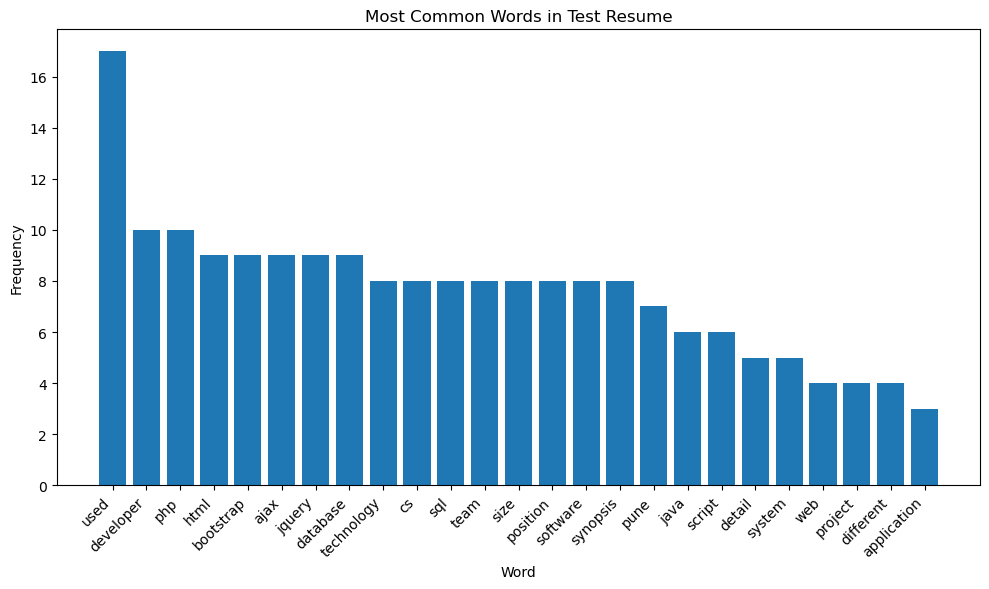

In [118]:
# Plot most common words and their frequency
words = [word for word, freq in test_wc]
frequencies = [freq for word, freq in test_wc]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Test Resume')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_test2')

In [119]:
# Java Developer Resumes
jdep = resumes[resumes["Category"] == "Java Developer"]
jdep_corpus = []
for i in range(len(jdep)):
    jdep_corpus.append(jdep["Cleaned Description"].iloc[i])
    jdep_str = ' '.join(jdep_corpus)
jdep_wc = count_words(jdep_str, 25)
jdep_wc

[('java', 87),
 ('exprience', 58),
 ('month', 53),
 ('developer', 47),
 ('detail', 43),
 ('technology', 36),
 ('description', 32),
 ('company', 31),
 ('year', 30),
 ('le', 29),
 ('maharashtra', 26),
 ('system', 25),
 ('skill', 24),
 ('project', 20),
 ('jsp', 19),
 ('january', 18),
 ('ajax', 17),
 ('spring', 16),
 ('database', 16),
 ('development', 16),
 ('mysql', 16),
 ('hibernate', 15),
 ('pvt', 14),
 ('language', 13),
 ('web', 13)]

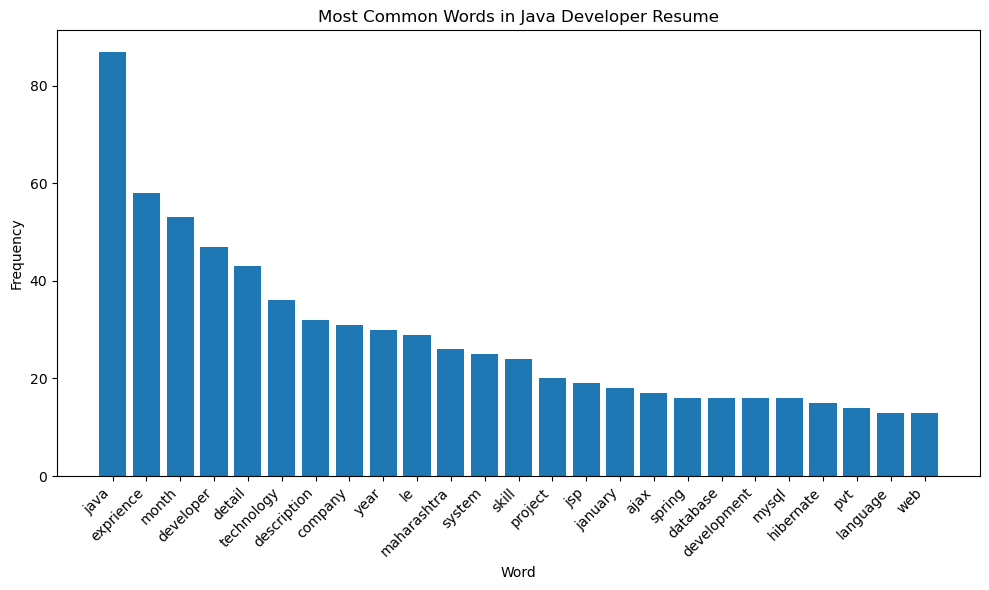

In [106]:
# Plot most common words and their frequency
words = [word for word, freq in jdep_wc]
frequencies = [freq for word, freq in jdep_wc]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Java Developer Resume')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_java')

In [121]:
# Web Designing Resumes
webd = resumes[resumes["Category"] == "Web Designing"]
webd = webd[webd["Resume Key"] != 37]
webd_corpus = []
for i in range(len(webd)):
    webd_corpus.append(webd["Cleaned Description"].iloc[i])
    webd_str = ' '.join(webd_corpus)
webd_wc = count_words(webd_str, 25)
webd_wc

[('project', 20),
 ('exprience', 16),
 ('description', 16),
 ('web', 14),
 ('application', 14),
 ('month', 13),
 ('company', 10),
 ('detail', 9),
 ('developed', 9),
 ('technology', 8),
 ('nagpur', 8),
 ('system', 8),
 ('requirement', 8),
 ('role', 7),
 ('responsibility', 7),
 ('ui', 7),
 ('designed', 7),
 ('website', 7),
 ('maharashtra', 6),
 ('designer', 6),
 ('graphic', 6),
 ('secondary', 6),
 ('skill', 5),
 ('html', 5),
 ('css', 5)]

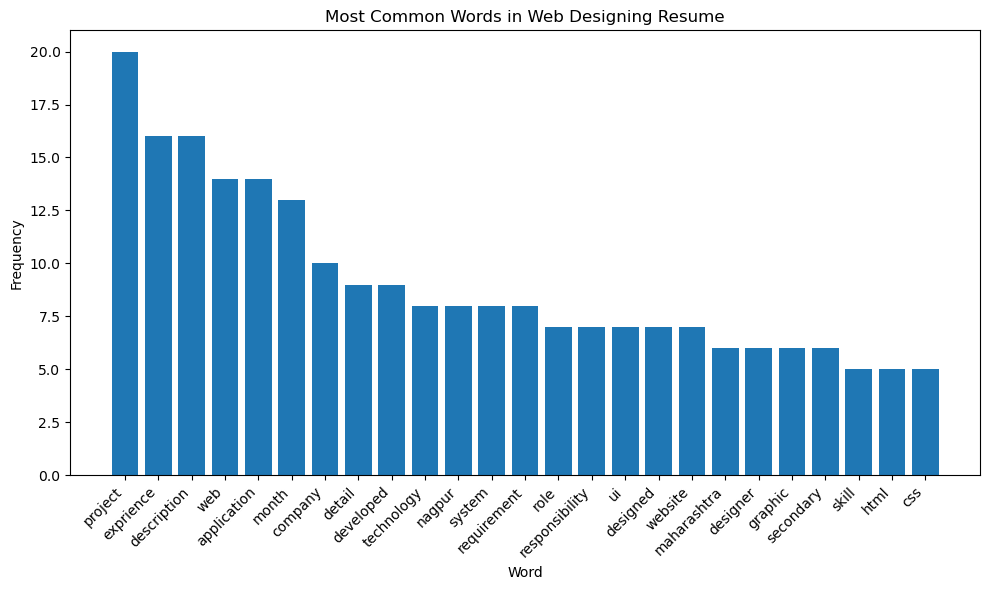

In [122]:
# Plot most common words and their frequency
words = [word for word, freq in webd_wc]
frequencies = [freq for word, freq in webd_wc]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Most Common Words in Web Designing Resume')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('CommonWords_res_webd')

In [123]:
jdep_common = common_first_elements(test_wc, jdep_wc)
jdep_common

{'ajax',
 'database',
 'detail',
 'developer',
 'java',
 'project',
 'system',
 'technology',
 'web'}

In [124]:
webd_common = common_first_elements(test_wc, webd_wc)
webd_common

{'application', 'detail', 'html', 'project', 'system', 'technology', 'web'}

In [125]:
# Once again, the model classifying this resume as Java Developer instead of Web Designing makes sense considering that
# according to word counts this resume fits more into java developer than it does with web designing.